# Stanford CME 241 (Winter 2026) - Assignment 2

**Due: Friday, February 13 @ 11:59 PM PST on Gradescope.**

Assignment instructions:
- Make sure each of the subquestions have answers
- Ensure that group members indicate which problems they're in charge of
- Show work and walk through your thought process where applicable
- Empty code blocks are for your use, so feel free to create more under each section as needed
- Document code with light comments (i.e. 'this function handles visualization')

Submission instructions:
- When complete, fill out your publicly available GitHub repo file URL and group members below, then export or print this .ipynb file to PDF and upload the PDF to Gradescope.

*Link to this ipynb file in your public GitHub repo (replace below URL with yours):* 

https://github.com/my-username/my-repo/assignment-file-name.ipynb

*Group members (replace below names with people in your group):* 
- Evan Ellington
- Yuming Huang
- Yusuke Atsuta

## Imports

In [20]:
import numpy as np
import matplotlib.pyplot as plt

## Question 1: Job-Hopping and Wages-Utility-Maximization (Led by Yusuke)

You are a worker who starts every day either employed or unemployed. If you start your day employed, you work on your job for the day (one of $n$ jobs, as elaborated later) and you get to earn the wage of the job for the day. However, at the end of the day, you could lose your job with probability $\alpha \in [0,1]$, in which case you start the next day unemployed. If at the end of the day, you do not lose your job (with probability $1-\alpha$), then you will start the next day with the same job (and hence, the same daily wage). 

On the other hand, if you start your day unemployed, then you will be randomly offered one of $n$ jobs with daily wages $w_1, w_2, \ldots w_n \in \mathbb{R}^+$ with respective job-offer probabilities $p_1, p_2, \ldots p_n \in [0,1]$ (with $\sum_{i=1}^n p_i = 1$). You can choose to either accept or decline the offered job. If you accept the job offer, your day progresses exactly like the **employed-day** described above (earning the day's job wage and possibly (with probability $\alpha$) losing the job at the end of the day). However, if you decline the job offer, you spend the day unemployed, receive the unemployment wage $w_0 \in \mathbb{R}^+$ for the day, and start the next day unemployed.

The problem is to identify the optimal choice of accepting or rejecting any of the job offers the worker receives, in a manner that maximizes the infinite-horizon **Expected Discounted-Sum of Wages Utility**. Assume the daily discount factor for wages (employed or unemployed) is $\gamma \in [0,1])$. Assume Wages Utility function to be $U(w) = \log(w)$ for any wage amount $w \in \mathbb{R}^+$. The goal is to maximize:

$$
\mathbb{E}\left[\sum_{u=t}^\infty \gamma^{u-t} \cdot \log(w_{i_u})\right]
$$

at the start of a given day $t$ ($w_{i_u}$ is the wage earned on day $u$, $0 \leq i_u \leq n$ for all $u \geq t$).

---

### Subquestions

#### Part (A): MDP Modeling

Express the job-hopping problem as an MDP using clear mathematical notation by defining the following components:

1. **State Space**: Define the possible states of the MDP.
2. **Action Space**: Specify the actions available to the worker at each state.
3. **Transition Function**: Describe the probabilities of transitioning between states for each action.
4. **Reward Function**: Specify the reward associated with the states and transitions.
5. **Bellman Optimality Equation**: Write the Bellman Optimality Equation customized for this MDP.

---

#### Part (B): Python Implementation

Write Python code that:

1. Solves the Bellman Optimality Equation (hence, solves for the **Optimal Value Function** and the **Optimal Policy**) with a numerical iterative algorithm. 
2. Clearly define the inputs and outputs of your algorithm with their types (`int`, `float`, `List`, `Mapping`, etc.).

*Note*: For this problem, write the algorithm from scratch without using any prebuilt MDP/DP libraries or code.

---

#### Part (C): Visualization and Analysis

1. Plot the **Optimal Value Function** as a function of the state for a specific set of parameters ($n$, $w_1, \ldots, w_n$, $p_1, \ldots, p_n$, $\alpha$, $\gamma$, $w_0$).
2. Include these graphs in your submission.

---

#### Part (D): Observations

1. What patterns do you observe in the **Optimal Policy** as you vary the parameters $n$, $\alpha$, and $\gamma$?
2. Provide a brief discussion of your findings.

---

### Part (A) Answer

**1. State Space**

$\mathcal S=\{0,1,\dots,n\}$,
where we let 0 denote unemployment and $i\ge1$ denote employment at job $i$.

**2. Action Space**

- If $s=i\ge1$: no choice (work).
- If $s=0$: after observing offer $i\sim(p_1,\dots,p_n)$ and thus $w_i$, choose $\{\text{accept},\text{reject}\}$.

**3. Transition Function**

- From $s=i\ge1$: $\mathbb P(0\mid i)=\alpha$, and $\mathbb P(i\mid i)=1-\alpha$.
- From $s=0$ with offer $i$:
    - accept: $\mathbb P(0)=\alpha,\quad \mathbb P(i)=1-\alpha$.
    - reject: $\mathbb P(0)=1$.

**4. Reward Function**

This is the utility function applied to the wage, i.e. $r(i)=\log(w_i)$.

**5. Bellman Optimality Equations**

For $i\ge1$:
$$
V_i=\log(w_i)+\gamma\left((1-\alpha)V_i+\alpha V_0\right).
$$

For unemployment:
$$
V_0=\sum_{i=1}^n p_i
\max\Big\{
\log(w_i)+\gamma ((1-\alpha)V_i+\alpha V_0),
\ \log(w_0)+\gamma V_0
\Big\}.
$$

### Part (B) Answer

In [23]:
import math
from dataclasses import dataclass
from typing import Dict, List


@dataclass(frozen=True)
class Inputs:
    unemployed_wage: float   # w_0
    wages: List[float]       # wages[i - 1] = w_i
    probs: List[float]       # probs[i - 1] = p_i
    alpha: float
    gamma: float
    tol: float = 1e-10
    max_iter: int = 100_000
    
    def __post_init__(self):
        self._validate_fields()
    
    def _validate_fields(self):
        if not self.wages:
            raise ValueError("wages must be nonempty")
        if len(self.probs) != len(self.wages):
            raise ValueError("probs must have same length as wages")
        if any(w <= 0 for w in self.wages) or self.unemployed_wage <= 0:
            raise ValueError("all wages must be > 0")
        if any(p < 0 for p in self.probs) or abs(sum(self.probs) - 1.0) > 1e-9:
            raise ValueError("probs must be nonnegative and sum to 1")
        if not (0.0 <= self.alpha <= 1.0):
            raise ValueError("alpha must be in [0,1]")
        if not (0.0 <= self.gamma < 1.0):
            raise ValueError("gamma must be in [0,1)")


@dataclass(frozen=True)
class Outputs:
    V0: float
    Vi: Dict[int, float]
    policy: Dict[int, bool]   
    # policy[i] = True if should accept offer i when unemployed,
    # False otherwise (i.e. stay unemployed)


def solve(inp: Inputs) -> Outputs:
    """
    Performs value interation on input 0, since the value functions for all other states can be 
    expressed in terms of it. Returns the optimal value function and policy.
    """
    n = len(inp.wages)
    logw = {i: math.log(w) for i, w in enumerate(inp.wages, start=1)}
    logw[0] = math.log(inp.unemployed_wage)
    p = {i: p for i, p in enumerate(inp.probs, start=1)}
    
    # value function Vi in terms of V0
    def Vi_from_V0(i: int, V0: float) -> float:
        return (logw[i] + inp.gamma * inp.alpha * V0) / (1.0 - inp.gamma * (1.0 - inp.alpha))
    
    # value of accepting offer i when unemployed, in terms of V0
    def value_accept(i: int, V0: float) -> float:
        return logw[i] + inp.gamma * ((1.0 - inp.alpha) * Vi_from_V0(i, V0) + inp.alpha * V0)
    
    # similar but for rejecting
    def value_reject(V0: float) -> float:
        return logw[0] + inp.gamma * V0

    # Bellman operator for V0
    def B(V0: float) -> float:
        rv = value_reject(V0)
        total = 0.0
        for i in range(1, n + 1):
            av = value_accept(i, V0)
            total += p[i] * (av if av >= rv else rv)
        return total
    
    # L-infinity distance between V0 and V0_new over all components
    def Linf_distance(V0: float, V0_new: float) -> float:
        diffs = [abs(V0_new - V0)]
        for i in range(1, n + 1):
            diffs.append(abs(Vi_from_V0(i, V0_new) - Vi_from_V0(i, V0)))
        return max(diffs)

    # value iteration on scalar fixed point V0 = B(V0)
    V0 = logw[0] / (1.0 - inp.gamma)  # initial guess: unemployed forever
    for i in range(inp.max_iter):
        V0_new = B(V0)
        if Linf_distance(V0, V0_new) < inp.tol:
            V0 = V0_new
            break
        V0 = V0_new
    if i == inp.max_iter - 1:
        print(f"WARNING: did not converge after {inp.max_iter} iterations")

    Vi: Dict[int, float] = {i: Vi_from_V0(i, V0) for i in range(1, n + 1)}
    rv = value_reject(V0)
    policy: Dict[int, bool] = {i: (value_accept(i, V0) >= rv) for i in range(1, n + 1)}

    return Outputs(V0=V0, Vi=Vi, policy=policy)

### Part (C) Answer

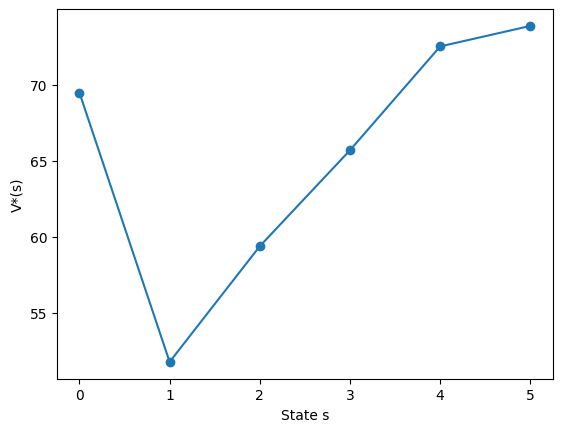

In [22]:
import matplotlib.pyplot as plt

inp = Inputs(
    unemployed_wage=1.0,
    wages=[0.7, 1.1, 1.6, 2.4, 2.6],
    probs=[0.30, 0.25, 0.30, 0.05, 0.10],
    alpha=0.05,
    gamma=0.99,
)

out = solve(inp)

states = list(range(6))
values = [out.V0] + [out.Vi[i] for i in sorted(out.Vi.keys())]

plt.figure()
plt.plot(states, values, marker="o")
plt.xlabel("State s")
plt.ylabel("V*(s)")
plt.xticks(states)
plt.show()

The parameters are as follows.
- 5 jobs with wages $0.7$, $1.1$, $1.6$, $2.4$, $2.6$ per day.
- Offer probabilities: $0.30$, $0.25$, $0.30$, $0.05$, $0.10$.
- Unemployment wage $1.0$ per day.
- $\alpha = 0.05$.
- $\gamma = 0.99$.

### Part (D) Answer

From the equations obtained in Part (B), we know that the value of accepting is strictly increasing in $w_i$. This implies that if the optimal policy accepts a job with wage $w_i$, it must also accept a job with wage greater than $w_i$. Similarly, if the policy rejects a job, it must also reject all jobs with a lower wage. Hence, there must be a threshold such that the optimal policy accepts all jobs with a higher wage and rejects all jobs with a lower wage. We may therefore characterize a policy by its threshold value.

In the following plots, we vary the parameters $n$, $\alpha$, and $\gamma$ while holding other parameters constant to see their effects on this threshold.

In [45]:
import numpy as np

def policy_threshold(wages: List[float], policy: Dict[int, bool]) -> float:
    """
    Returns the minimum wage such that the policy is to accept offers when unemployed.
    """
    if len(wages) != len(policy):
        raise ValueError("wages and policy must have same length")
    threshold = float('inf')
    for i, accept in policy.items():
        if accept:
            threshold = min(threshold, wages[i - 1])
    return threshold

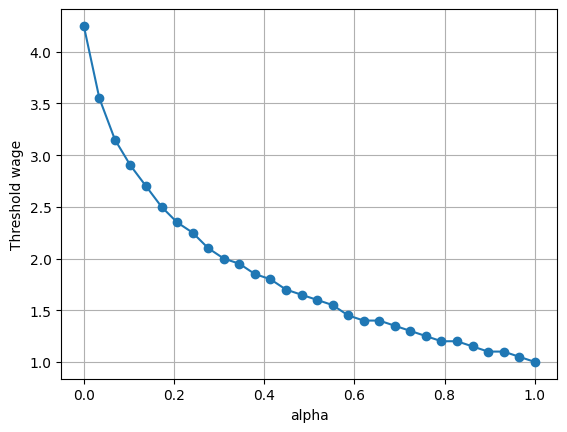

In [46]:
# plot threshold as a function of alpha
wages = np.linspace(0.05, 5.0, num=100).tolist()
probs = [0.01] * 100

alphas = np.linspace(0.0, 1.0, num=30)
thresholds = []
for alpha in alphas:
    inp_alpha = Inputs(
        unemployed_wage=1.0,
        wages=wages,
        probs=probs,
        alpha=alpha,
        gamma=0.99,
    )
    out_alpha = solve(inp_alpha)
    threshold = policy_threshold(inp_alpha.wages, out_alpha.policy)
    thresholds.append(threshold)
plt.figure()
plt.plot(alphas, thresholds, marker="o")
plt.xlabel("alpha")
plt.ylabel("Threshold wage")
plt.grid(True)
plt.show()

As $\alpha$ increases, accepted jobs are expected to last for a shorter duration, reducing the lock-in cost of accepting a low wage. So the threshold wage decreases and one becomes less selective.

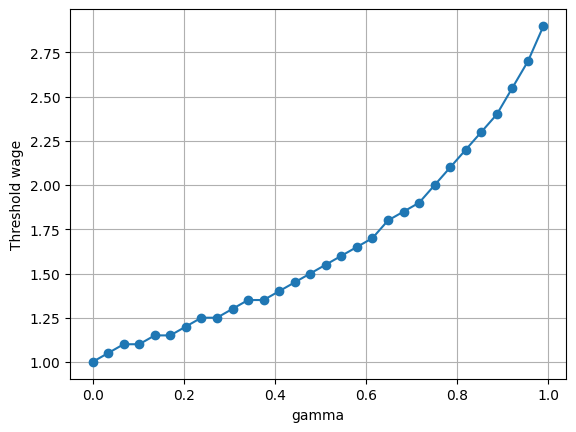

In [47]:
# threshold vs gamma
gammas = np.linspace(0.0, 0.99, num=30)
thresholds = []
for gamma in gammas:
    inp_gamma = Inputs(
        unemployed_wage=1.0,
        wages=wages,
        probs=probs,
        alpha=0.10,
        gamma=gamma,
    )
    out_gamma = solve(inp_gamma)
    threshold = policy_threshold(inp_gamma.wages, out_gamma.policy)
    thresholds.append(threshold)
plt.figure()
plt.plot(gammas, thresholds, marker="o")
plt.xlabel("gamma")
plt.ylabel("Threshold wage")
plt.grid(True)
plt.show()

Increasing $\gamma$ makes one more patient, prioritizing long-term reward while unemployed. This raises the value of waiting unemployed and therefore increases the threshold wage, making one more selective.

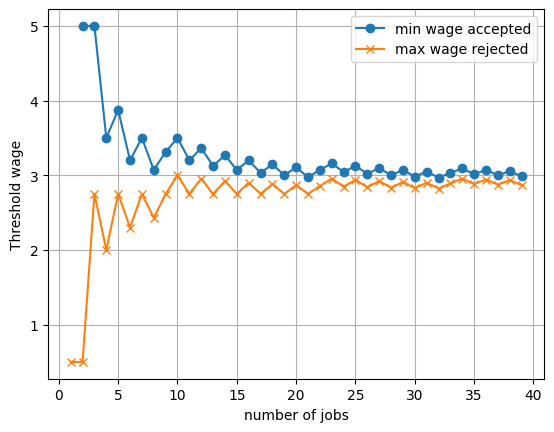

In [51]:
def policy_threshold_inf(wages: List[float], policy: Dict[int, bool]) -> float:
    if len(wages) != len(policy):
        raise ValueError("wages and policy must have same length")
    threshold = float('-inf')
    for i, accept in policy.items():
        if not accept:
            threshold = max(threshold, wages[i - 1])
    return threshold


# plot threshold as a function of number of jobs
num_jobs = list(range(1, 40))
thresholds_top = []
thresholds_bottom = []

for n in num_jobs:
    inp = Inputs(
        unemployed_wage=1.0,
        wages=np.linspace(0.5, 5.0, n).tolist(),
        probs=[1.0 / n] * n,
        alpha=0.10,
        gamma=0.99,
    )
    out = solve(inp)
    thresholds_top.append(policy_threshold(inp.wages, out.policy))
    thresholds_bottom.append(policy_threshold_inf(inp.wages, out.policy))
plt.figure()
plt.plot(num_jobs, thresholds_top, marker="o", label="min wage accepted")
plt.plot(num_jobs, thresholds_bottom, marker="x", label="max wage rejected")
plt.xlabel("number of jobs")
plt.ylabel("Threshold wage")
plt.grid(True)
plt.legend()
plt.show()

When the wage distribution is held fixed and $n$ is increased, the lowest accepted and highest rejected wages converge to the same value. This shows that $n$ only affects the observed threshold through discretization, i.e. higher $n$ allows us to observe the true threshold at a higher resolution.

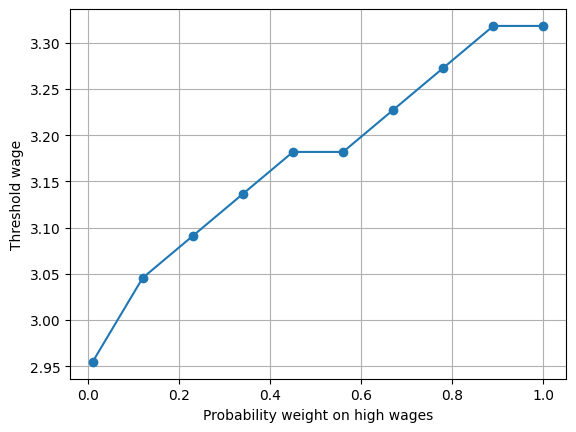

In [56]:
# threshold as a function of distribution of wages
# vary distribution from low wages more likely to high wages more likely

wages = np.linspace(0.5, 5.0, num=100).tolist()
prob_distributions = []

for i in range(10):
    probs = np.linspace(0.01, 1.0, num=100) ** (i / 9.0)
    probs /= probs.sum()
    prob_distributions.append(probs.tolist())

thresholds = []
for probs in prob_distributions:
    inp = Inputs(
        unemployed_wage=1.0,
        wages=wages,
        probs=probs,
        alpha=0.10,
        gamma=0.99,
    )
    out = solve(inp)
    threshold = policy_threshold(inp.wages, out.policy)
    thresholds.append(threshold)

plt.figure()
plt.plot(np.linspace(0.01, 1.0, num=10), thresholds, marker="o")
plt.xlabel("Probability weight on high wages")
plt.ylabel("Threshold wage")
plt.grid(True)
plt.show()

In the plot above, the $x$-axis represents how much the distribution of wages is skewed towards higher wages.
When higher wages are more probable, the expected value of remaining unemployed increases due to better future prospects,
which makes the threshold higher.

## Question 2: Two-Stores Inventory Control (Led by Yuming)

We extend the capacity-constrained inventory example implemented in [rl/chapter3/simple_inventory_mdp_cap.py](https://github.com/TikhonJelvis/RL-book/blob/master/rl/chapter3/simple_inventory_mdp_cap.py) as a `FiniteMarkovDecisionProcess` (the Finite MDP model for the capacity-constrained inventory example is described in detail in Chapters 1 and 2 of the RLForFinanceBook). Here we assume that we have two different stores, each with their own separate capacities $C_1$ and $C_2$, their own separate Poisson probability distributions of demand (with means $\lambda_1$ and $\lambda_2$), their own separate holding costs $h_1$ and $h_2$, and their own separate stockout costs $p_1$ and $p_2$. At 6pm upon stores closing each evening, each store can choose to order inventory from a common supplier (as usual, ordered inventory will arrive at the store 36 hours later). We are also allowed to transfer inventory from one store to another, and any such transfer happens overnight, i.e., will arrive by 6am next morning (since the stores are fairly close to each other). Note that the orders are constrained such that following the orders on each evening, each store's inventory position (sum of on-hand inventory and on-order inventory) cannot exceed the store's capacity (this means the action space is constrained to be finite). Each order made to the supplier incurs a fixed transportation cost of $K_1$ (fixed-cost means the cost is the same no matter how many units of non-zero inventory a particular store orders). Moving any non-zero inventory between the two stores incurs a fixed transportation cost of $K_2$. 

Model this as a derived class of `FiniteMarkovDecisionProcess` much like we did for `SimpleInventoryMDPCap` in the code repo. Set up instances of this derived class for different choices of the problem parameters (capacities, costs etc.), and determine the Optimal Value Function and Optimal Policy by invoking the function `value_iteration` (or `policy_iteration`) from file [rl/dynamic_programming.py](https://github.com/TikhonJelvis/RL-book/blob/master/rl/dynamic_programming.py).

Analyze the obtained Optimal Policy and verify that it makes intuitive sense as a function of the problem parameters.

In [15]:
# fill in with Python code
from dataclasses import dataclass
from typing import Tuple, Dict, Mapping
from rl.markov_decision_process import FiniteMarkovDecisionProcess
from rl.distribution import Categorical
from scipy.stats import poisson

@dataclass(frozen=True)
class TwoStores:
    on_hand_1: int
    on_order_1: int
    on_hand_2: int
    on_order_2: int

    def inventory_position_1(self) -> int:
        return self.on_hand_1 + self.on_order_1

    def inventory_position_2(self) -> int:
        return self.on_hand_2 + self.on_order_2

InvOrderMapping = Mapping[
    TwoStores,
    Mapping[int, Categorical[Tuple[TwoStores, float]]]
]


class DoubleInventoryMDPCap(FiniteMarkovDecisionProcess[TwoStores, Tuple[int, int, int]]):

    def __init__(
        self,
        capacity1: int,
        poisson_lambda1: float,
        holding_cost1: float,
        stockout_cost1: float,

        capacity2: int,
        poisson_lambda2: float,
        holding_cost2: float,
        stockout_cost2: float,

        fixed_order_cost: float,
        fixed_transfer_cost: float
    ):
        self.capacity1: int = capacity1
        self.poisson_lambda1: float = poisson_lambda1
        self.holding_cost1: float = holding_cost1
        self.stockout_cost1: float = stockout_cost1

        self.capacity2: int = capacity2
        self.poisson_lambda2: float = poisson_lambda2
        self.holding_cost2: float = holding_cost2
        self.stockout_cost2: float = stockout_cost2

        self.fixed_order_cost: float = fixed_order_cost
        self.fixed_transfer_cost: float = fixed_transfer_cost

        self.poisson_distr1 = poisson(poisson_lambda1)
        self.poisson_distr2 = poisson(poisson_lambda2)

        super().__init__(self.get_action_transition_reward_map())

    def get_action_transition_reward_map(self) -> InvOrderMapping:
        d: Dict[TwoStores, Dict[int, Categorical[Tuple[TwoStores, float]]]] = {}

        for alpha1 in range(self.capacity1 + 1):
            for beta1 in range(self.capacity1 + 1 - alpha1):
                for alpha2 in range(self.capacity2 + 1):
                    for beta2 in range(self.capacity2 + 1 - alpha2):
                        state = TwoStores(alpha1, beta1, alpha2, beta2)
                        ip1 = state.inventory_position_1()
                        ip2 = state.inventory_position_2()

                        action_dict = {}

                        for order1 in range(self.capacity1 - ip1 + 1):
                            for order2 in range(self.capacity2 - ip2 + 1):
                                for transfer in range(-alpha2, alpha1 + 1):

                                    oh1_after = alpha1 - transfer
                                    oh2_after = alpha2 + transfer

                                    avail1 = oh1_after + beta1
                                    avail2 = oh2_after + beta2

                                    base_reward = (
                                        - self.holding_cost1 * avail1
                                        - self.holding_cost2 * avail2
                                        - self.fixed_order_cost * (order1 > 0)
                                        - self.fixed_order_cost * (order2 > 0)
                                        - self.fixed_transfer_cost * (transfer != 0)
                                    )

                                    p1_out = 1 - self.poisson_distr1.cdf(avail1 - 1) if avail1 > 0 else 1.0
                                    p2_out = 1 - self.poisson_distr2.cdf(avail2 - 1) if avail2 > 0 else 1.0

                                    stockout_penalty_1 = self.stockout_cost1 * (
                                        self.poisson_lambda1 - avail1 *
                                        (1 - self.poisson_distr1.pmf(avail1) / p1_out)
                                    ) if avail1 > 0 else self.stockout_cost1 * self.poisson_lambda1

                                    stockout_penalty_2 = self.stockout_cost2 * (
                                        self.poisson_lambda2 - avail2 *
                                        (1 - self.poisson_distr2.pmf(avail2) / p2_out)
                                    ) if avail2 > 0 else self.stockout_cost2 * self.poisson_lambda2

                                    sr_probs_dict = {}

                                    # case: neither stocks out
                                    for d1 in range(avail1):
                                        for d2 in range(avail2):
                                            prob = (self.poisson_distr1.pmf(d1)
                                                    * self.poisson_distr2.pmf(d2))
                                            next_state = TwoStores(avail1 - d1, order1,
                                                                avail2 - d2, order2)
                                            reward = base_reward
                                            key = (next_state, reward)
                                            sr_probs_dict[key] = sr_probs_dict.get(key, 0) + prob

                                    # case: 1 stocks out, 2 doesn't
                                    for d2 in range(avail2):
                                        prob = p1_out * self.poisson_distr2.pmf(d2)
                                        next_state = TwoStores(0, order1,
                                                                avail2 - d2, order2)
                                        reward = base_reward - stockout_penalty_1
                                        key = (next_state, reward)
                                        sr_probs_dict[key] = sr_probs_dict.get(key, 0) + prob

                                    # case: 2 stocks out, 1 doesn't
                                    for d1 in range(avail1):
                                        prob = self.poisson_distr1.pmf(d1) * p2_out
                                        next_state = TwoStores(avail1 - d1, order1,
                                                                0, order2)
                                        reward = base_reward - stockout_penalty_2
                                        key = (next_state, reward)
                                        sr_probs_dict[key] = sr_probs_dict.get(key, 0) + prob

                                    # case: both stock out
                                    prob = p1_out * p2_out
                                    next_state = TwoStores(0, order1, 0, order2)
                                    reward = base_reward - stockout_penalty_1 - stockout_penalty_2
                                    key = (next_state, reward)
                                    sr_probs_dict[key] = sr_probs_dict.get(key, 0) + prob

                                    action_dict[(order1, order2, transfer)] = Categorical(sr_probs_dict)

                        d[state] = action_dict
        return d

In [16]:
from pprint import pprint
from rl.dynamic_programming import value_iteration_result, policy_iteration_result

si_mdp = DoubleInventoryMDPCap(
    capacity1=3,
    poisson_lambda1=1.0,
    holding_cost1=1.0,
    stockout_cost1=10.0,

    capacity2=1,
    poisson_lambda2=2.0,
    holding_cost2=1.0,
    stockout_cost2=10.0,

    fixed_order_cost=0,
    fixed_transfer_cost=10
)

gamma = 0.9

opt_vf, opt_policy = value_iteration_result(si_mdp, gamma=gamma)

print("Optimal Value Function")
pprint(opt_vf)
print()

print("Optimal Policy")
print(opt_policy)

Optimal Value Function
{NonTerminal(state=TwoStores(on_hand_1=0, on_order_1=0, on_hand_2=0, on_order_2=0)): -107.26703782297406,
 NonTerminal(state=TwoStores(on_hand_1=0, on_order_1=0, on_hand_2=0, on_order_2=1)): -102.04683827750267,
 NonTerminal(state=TwoStores(on_hand_1=0, on_order_1=0, on_hand_2=1, on_order_2=0)): -86.37831516667431,
 NonTerminal(state=TwoStores(on_hand_1=0, on_order_1=1, on_hand_2=0, on_order_2=0)): -109.98032158749072,
 NonTerminal(state=TwoStores(on_hand_1=0, on_order_1=1, on_hand_2=0, on_order_2=1)): -104.47743813473059,
 NonTerminal(state=TwoStores(on_hand_1=0, on_order_1=1, on_hand_2=1, on_order_2=0)): -88.09686400299846,
 NonTerminal(state=TwoStores(on_hand_1=0, on_order_1=2, on_hand_2=0, on_order_2=0)): -105.00748608835036,
 NonTerminal(state=TwoStores(on_hand_1=0, on_order_1=2, on_hand_2=0, on_order_2=1)): -99.97491155221842,
 NonTerminal(state=TwoStores(on_hand_1=0, on_order_1=2, on_hand_2=1, on_order_2=0)): -84.0712588124933,
 NonTerminal(state=TwoStores

In [17]:
from rl.markov_process import NonTerminal

def analyze(name, mdp, gamma=0.9):
    opt_vf, opt_policy = value_iteration_result(mdp, gamma=gamma)
    
    key_states = [
        (0, 0, 0, 0),
        (1, 0, 0, 0),
        (0, 0, 1, 0),
        (1, 0, 1, 0),
        (2, 0, 0, 0),
        (0, 0, 2, 0),
    ]
    
    print(f"\n{'='*60}")
    print(f"  {name}")
    print(f"{'='*60}")
    print(f"{'State':<20} {'Action (o1,o2,tr)':<20} {'Value':>10}")
    print("-" * 50)
    for (a1, b1, a2, b2) in key_states:
        s = TwoStores(a1, b1, a2, b2)
        nt = NonTerminal(s)
        if nt in opt_vf:
            action = opt_policy.act(nt).sample()
            print(f"({a1},{b1},{a2},{b2}){'':<10} {str(action):<20} {opt_vf[nt]:>10.2f}")

# Test 1: Vary K1
print("\n### Effect of K1 (fixed order cost) ###")
for k1 in [0, 5, 15, 30]:
    analyze(f"K1={k1}, K2=0", DoubleInventoryMDPCap(
        capacity1=2, poisson_lambda1=1.0, holding_cost1=1.0, stockout_cost1=10.0,
        capacity2=2, poisson_lambda2=1.0, holding_cost2=1.0, stockout_cost2=10.0,
        fixed_order_cost=k1, fixed_transfer_cost=0.0))

# Test 2: Vary K2
print("\n### Effect of K2 (fixed transfer cost) ###")
for k2 in [0, 5, 15, 50]:
    analyze(f"K1=0, K2={k2}", DoubleInventoryMDPCap(
        capacity1=2, poisson_lambda1=1.0, holding_cost1=1.0, stockout_cost1=10.0,
        capacity2=2, poisson_lambda2=1.0, holding_cost2=1.0, stockout_cost2=10.0,
        fixed_order_cost=0.0, fixed_transfer_cost=k2))

# Test 3: Vary lambda2
print("\n### Effect of asymmetric demand ###")
for lam2 in [0.5, 1.0, 2.0, 3.0]:
    analyze(f"lam1=1.0, lam2={lam2}", DoubleInventoryMDPCap(
        capacity1=2, poisson_lambda1=1.0, holding_cost1=1.0, stockout_cost1=10.0,
        capacity2=2, poisson_lambda2=lam2, holding_cost2=1.0, stockout_cost2=10.0,
        fixed_order_cost=0.0, fixed_transfer_cost=0.0))

# Test 4: Vary stockout cost
print("\n### Effect of asymmetric stockout costs ###")
for p2 in [5, 10, 30, 50]:
    analyze(f"p1=10, p2={p2}, K2=5", DoubleInventoryMDPCap(
        capacity1=2, poisson_lambda1=1.0, holding_cost1=1.0, stockout_cost1=10.0,
        capacity2=2, poisson_lambda2=1.0, holding_cost2=1.0, stockout_cost2=p2,
        fixed_order_cost=0.0, fixed_transfer_cost=5.0))


### Effect of K1 (fixed order cost) ###

  K1=0, K2=0
State                Action (o1,o2,tr)         Value
--------------------------------------------------
(0,0,0,0)           (2, 2, 0)                -46.98
(1,0,0,0)           (1, 2, 1)                -33.29
(0,0,1,0)           (2, 1, -1)               -33.29
(1,0,1,0)           (1, 1, -1)               -30.08
(2,0,0,0)           (0, 2, 2)                -22.11
(0,0,2,0)           (2, 0, -2)               -22.11

  K1=5, K2=0
State                Action (o1,o2,tr)         Value
--------------------------------------------------
(0,0,0,0)           (2, 2, 0)                -65.13
(1,0,0,0)           (0, 2, 1)                -47.56
(0,0,1,0)           (2, 0, -1)               -47.56
(1,0,1,0)           (0, 1, 1)                -45.21
(2,0,0,0)           (0, 2, 2)                -29.69
(0,0,2,0)           (2, 0, -2)               -29.69

  K1=15, K2=0
State                Action (o1,o2,tr)         Value
-------------------------------

We ran the four tests above. Each test analyzes the effect of one parameter holding everything else fixed. 

Test 1: We varied $K_1 \in \{0, 5, 15, 30\}$ with $K_2 = 0$.

At $K_1 = 0$, the policy orders both stores to capacity every period. At $K_1 = 5$, state $(1,0,0,0)$ skips ordering for store 1 and transfers the unit to store 2 instead since transferring is free. At $K_1 = 15$ and $30$, state $(0,0,0,0)$ only orders for one store since paying $K_1$ twice is too expensive, so the policy consolidates orders and uses free transfers to redistribute.

Test 2: We varied $K_2 \in \{0, 5, 15, 50\}$ with $K_1 = 0$.

At $K_2 = 0$, transfers happen frequently. At $K_2 = 15$, state $(1,0,1,0)$ stops transferring and just orders with $(1,1,0)$. At $K_2 = 50$, nearly all transfers disappear except extreme cases like $(2,0,0,0)$ where one store has everything and the other has nothing.

Test 3: We varied $\lambda_2 \in \{0.5, 1.0, 2.0, 3.0\}$ with $\lambda_1 = 1.0$ and $K_1 = K_2 = 0$.

At $\lambda_2 = 1.0$, values are symmetric. As $\lambda_2$ increases, inventory at store 2 becomes more valuable. At $\lambda_2 = 3.0$, state $(0,0,2,0)$ has value $-69.47$ while $(2,0,0,0)$ has value $-135.06$. The policy aggressively transfers toward store 2 since stockouts are more likely there.

Test 4: We varied $p_2 \in \{5, 10, 30, 50\}$ with $p_1 = 10$ and $K_2 = 5$.

At $p_2 = 10$, stores are symmetric. At $p_2 = 30$, state $(1,0,1,0)$ chooses $(1,1,1)$, transferring to store 2 despite the $K_2 = 5$ cost. The higher the stockout penalty at store 2, the more the policy prioritizes keeping it stocked.

Conclusion:

Across all tests, the policy responds as expected: it orders less when $K_1$ is high, transfers less when $K_2$ is high, and directs inventory toward whichever store has higher demand or stockout costs. This follows from the fact that the optimal policy is minimizing the total discounted cost, so it naturally balances ordering costs, transfer costs, holding costs, and stockout penalties.

## Question 3: Dynamic Price Optimization (Led by Evan)

You own a supermarket, and you are $T$ days away from Halloween 🎃. You have just received $M$ Halloween masks from your supplier. You want to dynamically set the selling price of the Halloween masks at the start of each day in a manner that maximizes your **Expected Total Sales Revenue** for Halloween masks this season (assume no one will buy Halloween masks after Halloween).

Assume that for each of the $T$ days, you are required to select a price for that day from one of $N$ prices $p_1, p_2, \dots, p_N \in \mathbb{R}$, and that price is the selling price for all masks on that day. Assume that the customer demand for the number of Halloween masks on any day is governed by a Poisson probability distribution with mean $\lambda_i \in \mathbb{R}$ if you select that day’s price to be $p_i$ (where $i$ is a choice among $1, 2, \dots, N$).

Note that on any given day, the demand could exceed the number of Halloween masks you have in the store, in which case the number of masks sold on that day will be equal to the number of Halloween masks you had at the start of that day.

We spoke about this example in class - referencing the slides here (if needed) could be helpful!

---

### Subquestions

#### Part (A): Bellman Optimality Equation

Write the **Bellman Optimality Equation** customized to this Markov Decision Process (MDP). Essentially, you need to express the **Optimal Value Function** $v_*$ recursively based on taking the best action in the current state and based on the subsequent random customer demand that would produce the appropriate reward and take you to the next state.

**Note**: The probability mass function of a Poisson distribution with mean $\lambda \in \mathbb{R}$ is given by:

$$
f(k) = \frac{e^{-\lambda} \lambda^k}{k!}, \quad k = 0, 1, 2, \dots
$$

---

#### Part (B): Boundary Conditions

To be able to solve the $v_*$ recursion, you need to know the values of $v_*$ for the boundary case (boundary states). Write down the boundary case(s) for the $v_*$ recursion.

---

#### Part (C): Numerical Solution

You can solve this $v_*$ recursion (hence, solve for the **Optimal Policy** $\pi_*$) with a numerical recursive algorithm (essentially a special form of Dynamic Programming algorithm customized to this problem). 

Write Python code for this algorithm that would enable you to dynamically set the selling price at the start of each day. Clearly define the inputs and outputs of your algorithm with their types (`int`, `float`, `List`, `Mapping`, etc.).

---


### Part (A) Answer

Generic Bellman Optimality Equation:
$$V^*(s) = \max_{a \in A} \{R(s,a) + \gamma \sum_{s' \in N} P(s,a,s')V^*(s') \}$$

For this problem, we have: state $s = (t,m)$, where $t \in \{0,1,...,T\}$ and $m \in \{0,1,...,M\}$. And actions $a \in \{1,...,N\}$.

Since demand is governed by a Poisson distribution: $D \sim Poisson( \lambda_a)$.

The reward of a state action pair is then: $r(m,a,D) = p_a*\min(D,m)$

State transitions are: <br>
$t' = t-1$ meaning that each day that passes, there is one less remaining day. <br>
$m' = m - \min(D,m)$ meaning that the next day's inventory is today's minus how many were sold today (which is the minimum of the demand for that day and the total remaining inventory)

Looking again at the generic Bellman Optimality Equation above: $$V^*(s) = \max_{a \in A} \{R(s,a) + \gamma \sum_{s' \in N} P(s,a,s')V^*(s') \}$$<br>
And looking at the set up of this problem, we have: <br>
$\gamma = 1$ because there is no discount factor here. <br>
$P(s,a,s') = P((t,m),a,(t-1,m'))$ where $P(D=k) = \frac{e^{-\lambda_a}\lambda_a ^k}{k!}$<br>
$R(s,a) = R((t,m),a) = \mathbb{E}\big[ p_a \cdot \min(D,m) \big] = \sum_{k=0}^{\inf} \frac{e^{-\lambda_a}\lambda_a ^k}{k!} p_a \cdot \min(D,m)$ <br>

Plugging this into the generic version, we get: <br>
$$V^*(t,m) = \max_{a \in A} \{\sum_{k=0}^{\inf} \frac{e^{-\lambda_a}\lambda_a ^k}{k!} p_a \cdot \min(k,m) + \sum_{m'=0}^{M} P((t,m),a,(t-1,m'))V^*(t-1,m') \}$$




### Part (B) Answer

The boundary conditions are: <br>
$V^*(0,m) = 0\ \  \forall\ m$  this is when there are zero days, left and we have m masks left, but no one if going to buy any masks after halloween, so the value function will be zero no matter how many masks we have left.<br>
and <br>
$V^*(t,0) = 0\  \ \forall\ t$  this is when there are zero masks left, and there are t days left. The value function will also be zero here for any number t since no matter how long before halloween it is, we will have no masks to sell.



### Part (C) Answer

In [4]:
# fill in with Python code

from typing import List, Tuple
import math

def poisson(k: int, lam: float) -> float:
    return math.exp(-lam) * lam**k / math.factorial(k)

def num_rec_alg(T: int, M: int, prices: List[float], lambdas: List[float]) -> Tuple[List[List[float]], List[List[int]]]:
    N = len(prices)
    # DP table: v_star[t][m] = expected revenue with t days left and m masks
    v_star = [[0.0 for m in range(M+1)] for t in range(T+1)]
    # Policy table: pi_star[t][m] = best price index
    pi_star = [[0 for m in range(M+1)] for t in range(T+1)]
    
    # Backward DP
    for t in range(1, T+1):
        for m in range(1, M+1):
            best_val = -float('inf')
            best_action = 0
            for a in range(N):
                p = prices[a]
                lam = lambdas[a]
                # Expected revenue summing exactly from 0 to m, and probability mass for demand > m
                exp_rev = 0.0
                prob_cum_gt_m = 1.0  # start with total probability
                for k in range(m+1):
                    prob = poisson(k, lam)
                    exp_rev += prob * (p * k + v_star[t-1][m-k])
                    prob_cum_gt_m -= prob
                # Add revenue for demand > m
                exp_rev += prob_cum_gt_m * (p * m + v_star[t-1][0])
                
                if exp_rev > best_val:
                    best_val = exp_rev
                    best_action = a
            
            v_star[t][m] = best_val
            pi_star[t][m] = best_action
    
    return v_star, pi_star


## Question 4: Risk-Aversion and Utility Optimization under CARA Utility (Led by Yusuke)

You are tasked with analyzing the behavior of an investor who seeks to maximize their utility under **CARA Utility**. The investor has wealth $W$ and the CARA utility function:

$$
U(W) = \frac{1 - e^{-aW}}{a}, \quad a > 0,
$$

where $a$ represents the investor's **risk aversion**.

The investor allocates their wealth between:
1. A **riskless asset** with a fixed return $r$, and
2. A **risky asset** with return $R \sim \mathcal{N}(\mu, \sigma^2)$

The investor allocates a fraction $\pi$ of their wealth to the risky asset and $(1 - \pi)$ to the riskless asset. The wealth $W$ after one year is given by:

$$
W = (1 + r)(1 - \pi) + (1 + R)\pi.
$$

The goal is to analyze the investor’s optimal allocation $\pi$ to the risky asset and compute key risk-related quantities.

---

### Subquestions

#### Part (A): Expected Utility and Certainty-Equivalent Wealth

1. Derive the expression for the **expected utility** $\mathbb{E}[U(W)]$, using the given CARA utility function and assuming $R \sim \mathcal{N}(\mu, \sigma^2)$.
2. Using a Taylor expansion, approximate the **certainty-equivalent wealth** $W_{CE}$ up to second-order terms.

---

#### Part (B): Optimal Portfolio Allocation

Derive the optimal fraction $\pi^*$ of wealth to be allocated to the risky asset such that the **expected utility** $\mathbb{E}[U(W)]$ is maximized. Express $\pi^*$ in terms of $a$, $\mu$, $r$, and $\sigma^2$.

---

#### Part (C): Risk Premium

1. Using the results from Part (A), calculate the **absolute risk premium** $\pi_A = \mathbb{E}[W] - W_{CE}$.
2. Verify that $\pi_A \approx \frac{a \pi^2 \sigma^2}{2}$ for small $\sigma^2$.

---

#### Part (D): Numerical Calculations and Interpretation

Given the parameters $r = 0.02$, $\mu = 0.08$, $\sigma^2 = 0.04$, and $a = 3$:
1. Compute the optimal allocation $\pi^*$.
2. Calculate the certainty-equivalent wealth $W_{CE}$.
3. Compute the absolute risk premium $\pi_A$.
4. Interpret the results and discuss how changes in $a$ and $\sigma^2$ affect the risk premium and portfolio allocation.

---

#### Part (E): Expected Utility under Uniform Distribution

Now assume that the return of the risky asset, $R$, is no longer normally distributed. Instead, $R \sim \text{Uniform}[\alpha, \beta]$, where $\alpha$ and $\beta$ are the lower and upper bounds of the distribution, respectively.

1. Derive the new expression for the **expected utility** $\mathbb{E}[U(W)]$. Make sure to simplify your result as much as possible, and ensure that it explicitly depends on $a$, $\pi$, $\alpha$, $\beta$, and $r$.

**Hint**: Use the fact that if $W \sim \text{Uniform}[w_{\text{min}}, w_{\text{max}}]$, then:

$$
\mathbb{E}[g(W)] = \frac{1}{w_{\text{max}} - w_{\text{min}}} \int_{w_{\text{min}}}^{w_{\text{max}}} g(W) \, dW.
$$

---

### Part (A) Answer

#### Subpart 1.
Note that $1 + R \sim \mathcal N (1 + \mu, \sigma^2)$. Also, we know that the moment generating function of a $X \sim \mathcal N(\mu, \sigma^2)$ variable is
$$M_X(t) = \mathbb E[e^{tX}] = \exp (\mu t + \tfrac 12 \sigma^2 t^2).$$
We can thus evaluate
$$\begin{align*}
\mathbb E [e^{-a \pi (1 + R)}] &= M_{1 + R}(-a \pi) \\
&= \exp \big((1 + \mu)(-a \pi) + \tfrac 12 \sigma^2 a^2 \pi^2 \big).
\end{align*}$$
Therefore,
$$\begin{align*}
\mathbb E [U(W)] &= \frac{1 - e^{-a (1 + r)(1 - \pi)} \mathbb E [e^{-a \pi (1 + R)}]} a \\
&= \frac{1 - \exp \big(-a (1 + r)(1 - \pi) - (1 + \mu)(a \pi) + \tfrac 12 \sigma^2 a^2 \pi^2 \big) } a \\
&= \frac{1 - \exp (-a - ar - a\pi\mu + a \pi r + \tfrac 12 \sigma^2 a^2 \pi^2 ) } a.
\end{align*}$$

#### Subpart 2.
From the lectures, taking second-order Taylor expansions of $U(W_{CE})$ and $\mathbb E[U(W)]$ gives the approximation
$$\overline{W} - W_{CE} \approx - \frac 12 \cdot \frac{U''(W)}{U'(W)} \cdot \sigma^2_W.$$
We first find the distribution of $W$. Note that it is a linear transformation of a Gaussian variable, so it must also be Gaussian. We have 
$(1 + R) \pi \sim \mathcal N(\pi \mu, \pi^2 \sigma^2)$, so
$$W \sim \mathcal N(\pi \mu + 1 + r - r \pi, \pi^2 \sigma^2).$$
Then, we find the derivatives of $U$. We have
$$U'(W) = \tfrac 1a (ae^{-aW}) = e^{-aW},$$
and $U''(W) = -ae^{aW}$, so $U''(W) / U'(W) = -a$. Substituting everything, we have
$$\begin{align*}
W_{CE} &= \overline W - \frac 12 a \sigma_W^2 \\
&= \pi \mu + 1 + r - r \pi - \frac 12 a \pi^2 \sigma^2.
\end{align*}$$

_N.B._ One can also directly solve $U(W_{CE}) = \mathbb E [U(W)]$. Since 
$x \mapsto (1 - \exp (x))/a$
is monotonic and thus injective, the equation above simplifies to
$$-aW_{CE} = -a - ar - a\pi\mu + a \pi r + \frac 12 \sigma^2 a^2 \pi^2,$$
which gives the same result as the approximation.

### Part (B) Answer

Since $U(W_{CE}) = \mathbb E [U(W)]$ and $U$ is monotone increasing, maximizing the RHS, which is the expected utility, is equivalent to maximizing the certainty-equivalent wealth $W_{CE}$. From Part (A) 1, we have
$$W_{CE} = 1 + r + \pi (\mu - r) - \frac a2 \sigma^2 \pi^2.$$
This is a concave quadratic function in $\pi$, so the global unconstrained maximizer is
$$\pi^*_{\text{unconstrained}} = -\frac{\mu - r}{2(-a\sigma^2 / 2)} = \frac{\mu - r}{a \sigma^2}.$$
We additionally have the constraint $\pi \in [0, 1]$. Since $W_{CE}$ is quadratic, the constrained maximizer is simply the clipped global maximizer. Therefore,
$$\pi^* = \operatorname{proj}_{[0, 1]} \left( \frac{\mu - r}{a \sigma^2} \right).$$

### Part (C) Answer

#### Subpart 1.

From the problem statement, we have

$$W = (1 - \pi)(1 + r) + \pi(1 + R).$$

Taking the expectation and using $\mathbb{E}[R] = \mu$:

$$\mathbb{E}[W] = (1 - \pi)(1 + r) + \pi(1 + \mu) = 1 + r + \pi(\mu - r).$$

From Part (A) Subpart 2, we derived

$$W_{CE} = 1 + r + \pi(\mu - r) - \frac{1}{2} a \pi^2 \sigma^2.$$

Therefore, 

$$\pi_A = \mathbb{E}[W] - W_{CE} = [1 + r + \pi(\mu - r)] - [1 + r + \pi(\mu - r) - \tfrac{1}{2} a \pi^2 \sigma^2] = \frac{1}{2} a \pi^2 \sigma^2.$$



#### Subpart 2.

In Part (A) Subpart 2, we already showed via a second-order Taylor expansion that

$$\pi_A \approx \frac{1}{2} \left( -\frac{U''(\mathbb{E}[W])}{U'(\mathbb{E}[W])} \right) \text{Var}(W) = \frac{1}{2} a \pi^2 \sigma^2,$$

using the fact that $-U''/U' = a$ and $\text{Var}(W) = \pi^2 \sigma^2$. This matches the exact result from Subpart 1. 

### Part (D) Answer

In [74]:
from numpy.typing import NDArray
from typing import Union

Data = Union[float, NDArray]

r = 0.02
mu = 0.08
var = 0.04
a = 3

def optimal_pi(r: Data, mu: Data, var: Data, a: Data) -> Data:
    pi =  (mu - r) / (a * var)
    return np.clip(pi, 0.0, 1.0)

def certainty_equivalent(r: Data, mu: Data, var: Data, a: Data, pi: Data) -> Data:
    return 1 + r + pi * (mu - r) - 0.5 * a * var * pi ** 2

def abs_risk_premium(var: Data, a: Data, pi: Data) -> Data:
    return 0.5 * a * var * pi ** 2

pi = optimal_pi(r, mu, var, a)
print(f"Optimal allocation: \t\t\t{pi:.4f}")

print(f"Certainty equivalent wealth: \t\t{certainty_equivalent(r, mu, var, a, pi):.4f}")
print(f"Absolute risk premium: \t\t\t{abs_risk_premium(var, a, pi):.4f}")

Optimal allocation: 			0.5000
Certainty equivalent wealth: 		1.0350
Absolute risk premium: 			0.0150


/var/folders/dt/7fvg35wj34ngqcrqp1qbhj240000gn/T/ipykernel_7545/3183580533.py:12: RuntimeWarning: divide by zero encountered in divide
  pi =  (mu - r) / (a * var)


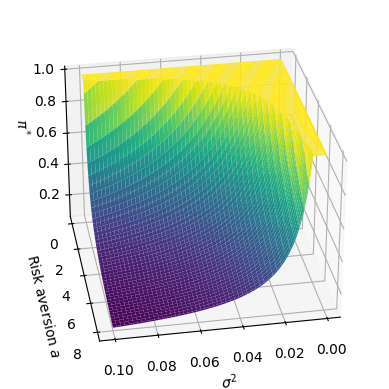

In [116]:
import numpy as np
import matplotlib.pyplot as plt

var_grid = np.linspace(0.001, 0.1, num=400)
a_grid = np.linspace(0, 8, num=100)

var_mesh, a_mesh = np.meshgrid(var_grid, a_grid)
pi_mesh = optimal_pi(r, mu, var_mesh, a_mesh)
risk_premium_mesh = abs_risk_premium(var_mesh, a_mesh, pi_mesh)


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.view_init(30, 80)
ax.plot_surface(var_mesh, a_mesh, pi_mesh, cmap='viridis')
ax.set_xlabel('$\sigma^2$')
ax.set_ylabel('Risk aversion $a$')
ax.set_zlabel('$\pi^*$')
plt.show()

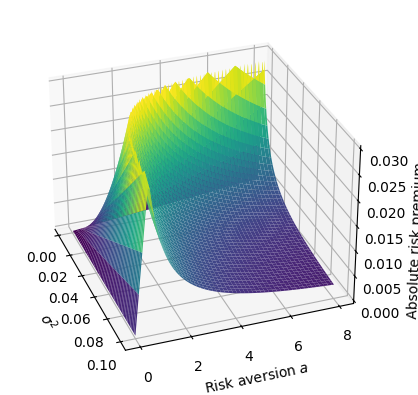

In [117]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.view_init(30, -20)
ax.plot_surface(var_mesh, a_mesh, risk_premium_mesh, cmap='viridis')
ax.set_xlabel('$\sigma^2$')
ax.set_ylabel('Risk aversion $a$')
ax.set_zlabel('Absolute risk premium')
plt.show()

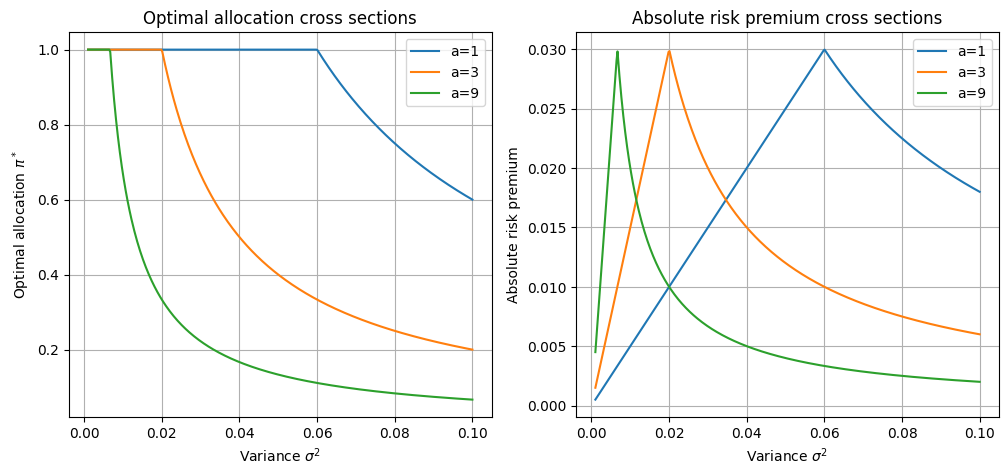

In [119]:
a_values = np.array([1, 3, 9])
var_values = var_grid

a_mesh, var_mesh = np.meshgrid(a_values, var_values)
pi_mesh = optimal_pi(r, mu, var_mesh, a_mesh)
risk_premium_mesh = abs_risk_premium(var_mesh, a_mesh, pi_mesh)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
for i, a_val in enumerate(a_values):
    plt.plot(var_values, pi_mesh[:, i], label=f'a={a_val}')
plt.xlabel('Variance $\sigma^2$')
plt.ylabel('Optimal allocation $\pi^*$')
plt.title('Optimal allocation cross sections')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
for i, a_val in enumerate(a_values):
    plt.plot(var_values, risk_premium_mesh[:, i], label=f'a={a_val}')
plt.xlabel('Variance $\sigma^2$')
plt.ylabel('Absolute risk premium')
plt.title('Absolute risk premium cross sections')
plt.legend()
plt.grid(True)
plt.show()

If the risky asset has low variance, it is optimal to allocate entirely to the risky asset, since the risk does not offset the additional 6% in return. As variance increases, the optimal allocation to the risky asset decreases and tends to 0. The decrease happens at a lower variance level for higher values of $a$, which corresponds to more risk aversion.

The risk premium increases with respect to variance (almost by definition) when the allocation is held constant at 1. Then, at higher variances, $\pi^*$ falls quickly enough so that the premium decreases as variance increases. Higher values of $a$ shifts the graph leftwards, since more risk-averse investors demand a higher premium for lower risk.

### Part (E) Answer

We have
$$
W=(1+r)(1-\pi)+(1+R)\pi.
$$

An affine transformation of a uniformly distributed variable is also uniform. Therefore, since $\pi > 0$ (no shorting), the wealth $W$ is distributed as
$$
W\sim\mathrm{Uniform}[w_{\min},w_{\max}],
$$
where we have 
$$\begin{align*}
w_{\min}&=(1+r)(1-\pi)+(1+\alpha)\pi, \\
w_{\max}&=(1+r)(1-\pi)+(1+\beta)\pi,
\end{align*}$$
and $w_{\max}-w_{\min}=\pi(\beta-\alpha)$. Therefore,
$$
\begin{align*}
\mathbb E[U(W)] &= \frac{1-\mathbb E[e^{-aW}]}{a} \\
&= \frac{1}a - \frac 1a \left( \frac{1}{w_{\max}-w_{\min}}
\int_{w_{\min}}^{w_{\max}} e^{-aw}\,dw \right)  \\
&= \frac 1a - \frac{1}{a \pi(\beta-\alpha)} \left[-e^{-aw}/a \right]_{w_{\min}}^{w_{\max}} \\
&= \frac 1a + \frac{e^{-aw_{\max}}-e^{-aw_{\min}}}{a^2\pi(\beta-\alpha)} \\
&=
\frac{1}{a}
+ \frac{e^{-a - ar+ a r \pi}}{a^2\pi(\beta-\alpha)}
( e^{-a\pi\beta}-e^{-a\pi\alpha} ).
\end{align*}
$$
